# Test evaluation task suite for AI data designer

Setup API key to run tests below

In [298]:
import sys
import os

# Define the root directory and add it to the path
notebook_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(notebook_dir, '..', '..', '..'))
sys.path.insert(0, root_dir)

# set environment variable 'GRETEL_PROD_API_KEY' from https://console.gretel.ai/users/me/key
gretel_prod_api_key = input("Enter your Gretel API key from https://console.gretel.ai/users/me/key: ")
os.environ['GRETEL_PROD_API_KEY'] = gretel_prod_api_key

### Evaluate Synthetic Dataset

In [299]:
# Reload packages if you've made changes to the evaluation.py file.
# Alternatively you can restart the kernel to pick up changes

from importlib import reload
import evaluation
reload(evaluation)

import pandas as pd
from pprint import pprint
from navigator_helpers.llms.llm_suite import GretelLLMSuite
from evaluation import BaseEvaluationTaskSuite, NL2PythonEvaluationTaskSuite, NL2SQLEvaluationTaskSuite, VisualizationTaskSuite
from datasets import load_dataset

In [300]:
datasets_dict = {
    "synthetic_text_to_sql": {
        "dataset_kwargs": {
            "path": "gretelai/synthetic_text_to_sql",
            "split": "train"
        },
        "code_lang": "sql",
        "eval_kwargs":{
            "instruction_col_name": "sql_prompt",
            "code_col_name": "sql",
            "context_col_name": "sql_context"
        }
    },
    "gsm8k": {
        "dataset_kwargs": {
            "path": "openai/gsm8k",
            "name": "main",
            "split": "train"
        },
        "eval_kwargs": {
            "instruction_col_name": "question",
            "code_col_name": "answer",
        }
    },
    "synthetic_gsm8k": {
        "dataset_kwargs": {
            "path": "gretelai/synthetic-gsm8k-reflection-405b",
            "split": "train"
        },
        "eval_kwargs": {
            "instruction_col_name": "question",
            "code_col_name": "answer",
        }
    },
    "xlcost_text_to_code": {
        "dataset_kwargs": {
            "path": "codeparrot/xlcost-text-to-code",
            "split": "train"
        },
        "code_lang": "python",
        "eval_kwargs": {
            "instruction_col_name": "text",
            "code_col_name": "code",
        }
    },
}

# Prompt user to select a dataset
print("Available datasets:")
for key in datasets_dict.keys():
    print(f" - {key}")

selected_dataset = input("\nEnter the name of the dataset to load: ").strip()

# Load the selected dataset
if selected_dataset in datasets_dict:
    dataset_dict = datasets_dict[selected_dataset]
    eval_kwargs = dataset_dict["eval_kwargs"]
    code_lang = dataset_dict["code_lang"] if "code_lang" in dataset_dict.keys() else None
    dataset = load_dataset(**dataset_dict["dataset_kwargs"])
    
    # Optionally, select a subset and convert to pandas DataFrame
    dataset_1000 = dataset.select(range(1000))
    dataset_1000_pd = dataset_1000.to_pandas()
    
    print(f"Loaded dataset '{selected_dataset}' successfully!")
else:
    print("Error: Dataset not found. Please enter a valid dataset name.")

Available datasets:
 - synthetic_text_to_sql
 - gsm8k
 - synthetic_gsm8k
 - xlcost_text_to_code
Loaded dataset 'synthetic_text_to_sql' successfully!


In [301]:
llm_suite = GretelLLMSuite()

2024-10-10 01:41:14.901 - INFO - 🦜 Initializing LLM suite
2024-10-10 01:41:14.903 - INFO - 📖 Natural language LLM: gretelai-mistral-nemo-2407
2024-10-10 01:41:14.904 - INFO - 💻 Code LLM: gretelai-mistral-nemo-2407
2024-10-10 01:41:14.905 - INFO - ⚖️ Judge LLM: gretelai-mistral-nemo-2407


In [302]:
results_1 = BaseEvaluationTaskSuite(llm_suite, dataset_1000_pd).row_uniqueness()
pprint(results_1)

{'non_semantically_unique_ids': [(2, 905), (78, 595), (192, 939), (272, 378)],
 'non_unique_ids': [],
 'percent_semantically_unique': 99.6,
 'percent_unique': 100.0}


In [303]:

results_2 = BaseEvaluationTaskSuite(llm_suite, dataset_1000_pd).feature_cardinality()
pprint(results_2)

{'domain': 0.1,
 'domain_description': 0.1,
 'id': 1.0,
 'sql': 1.0,
 'sql_complexity': 0.008,
 'sql_complexity_description': 0.008,
 'sql_context': 0.996,
 'sql_explanation': 1.0,
 'sql_prompt': 1.0,
 'sql_task_type': 0.004,
 'sql_task_type_description': 0.004}


In [304]:

results_3 = BaseEvaluationTaskSuite(llm_suite, dataset_1000_pd).feature_distribution()
pprint(results_3)

({'domain': {'aerospace': 6,
             'agriculture': 8,
             'aquaculture': 15,
             'archeology': 8,
             'arctic research': 4,
             'artificial intelligence': 12,
             'arts and culture': 8,
             'arts operations and management': 15,
             'automotive': 16,
             'beauty industry': 11,
             'biotechnology': 11,
             'blockchain': 6,
             'cannabis industry': 7,
             'charitable organizations': 15,
             'chemicals': 9,
             'civil engineering': 9,
             'climate change': 12,
             'construction': 17,
             'cosmetics': 4,
             'cultural preservation': 8,
             'cybersecurity': 13,
             'defense contractors': 5,
             'defense industry': 9,
             'defense operations': 13,
             'defense security': 16,
             'disability services': 11,
             'education': 9,
             'energy': 8,
             'e

In [305]:

results_4 = BaseEvaluationTaskSuite(llm_suite, dataset_1000_pd).num_words_per_record()
pprint(results_4)

{'average_words_per_record': 13.046100000000001,
 'word_counts_per_column': {'domain': 1.687,
                            'domain_description': 13.197,
                            'sql': 15.635,
                            'sql_complexity': 1.694,
                            'sql_complexity_description': 8.028,
                            'sql_context': 32.493,
                            'sql_explanation': 35.021,
                            'sql_prompt': 13.867,
                            'sql_task_type': 2.896,
                            'sql_task_type_description': 5.943}}


In [306]:
results = BaseEvaluationTaskSuite(llm_suite, dataset_1000_pd).evaluate_all()
pprint(results)

{'feature_cardinality': {'domain': 0.1,
                         'domain_description': 0.1,
                         'id': 1.0,
                         'sql': 1.0,
                         'sql_complexity': 0.008,
                         'sql_complexity_description': 0.008,
                         'sql_context': 0.996,
                         'sql_explanation': 1.0,
                         'sql_prompt': 1.0,
                         'sql_task_type': 0.004,
                         'sql_task_type_description': 0.004},
 'feature_distribution': ({'domain': {'aerospace': 6,
                                      'agriculture': 8,
                                      'aquaculture': 15,
                                      'archeology': 8,
                                      'arctic research': 4,
                                      'artificial intelligence': 12,
                                      'arts and culture': 8,
                                      'arts operations and m

In [310]:
results = NL2PythonEvaluationTaskSuite(llm_suite, dataset_1000_pd, code_lang="python").evaluate_all()
pprint(results)

{'feature_cardinality': {'domain': 0.1,
                         'domain_description': 0.1,
                         'id': 1.0,
                         'sql': 1.0,
                         'sql_complexity': 0.008,
                         'sql_complexity_description': 0.008,
                         'sql_context': 0.996,
                         'sql_explanation': 1.0,
                         'sql_prompt': 1.0,
                         'sql_task_type': 0.004,
                         'sql_task_type_description': 0.004},
 'feature_distribution': ({'domain': {'aerospace': 6,
                                      'agriculture': 8,
                                      'aquaculture': 15,
                                      'archeology': 8,
                                      'arctic research': 4,
                                      'artificial intelligence': 12,
                                      'arts and culture': 8,
                                      'arts operations and m

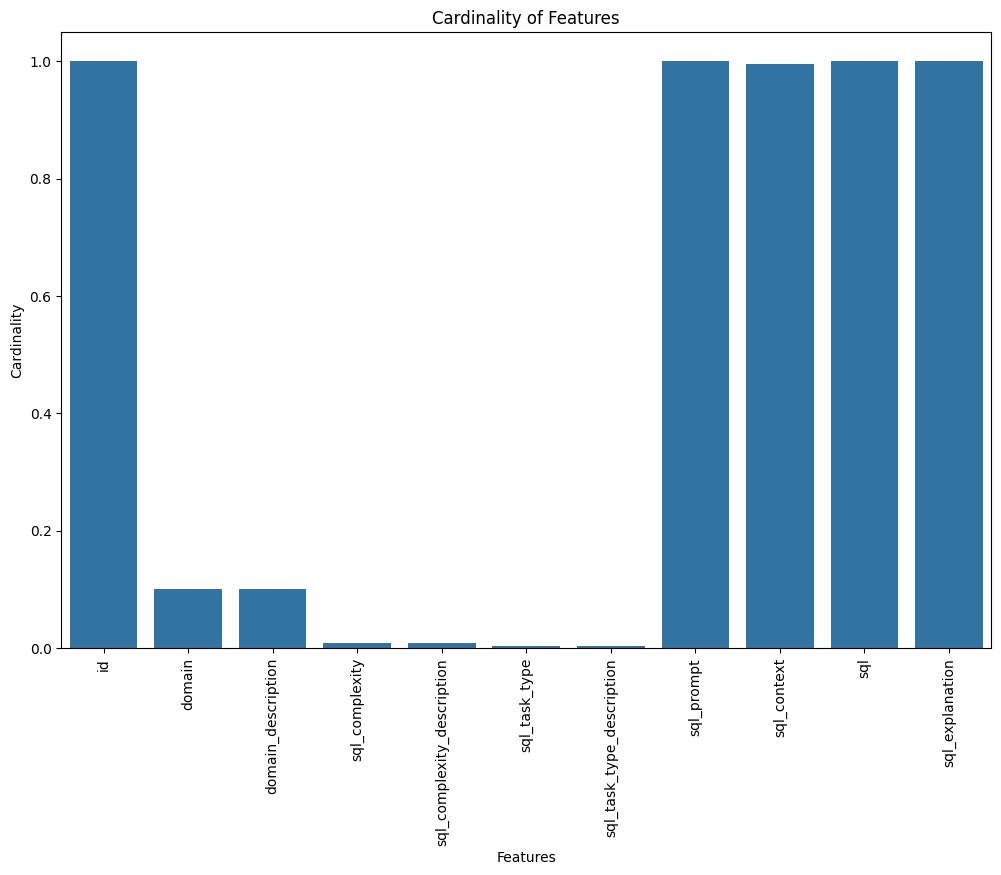

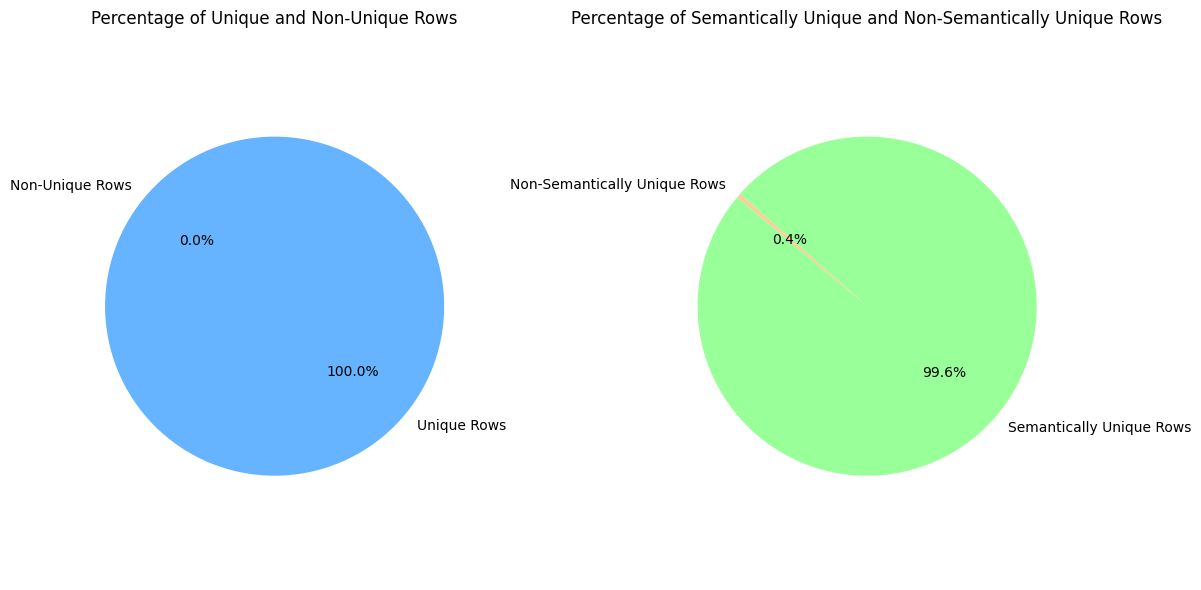

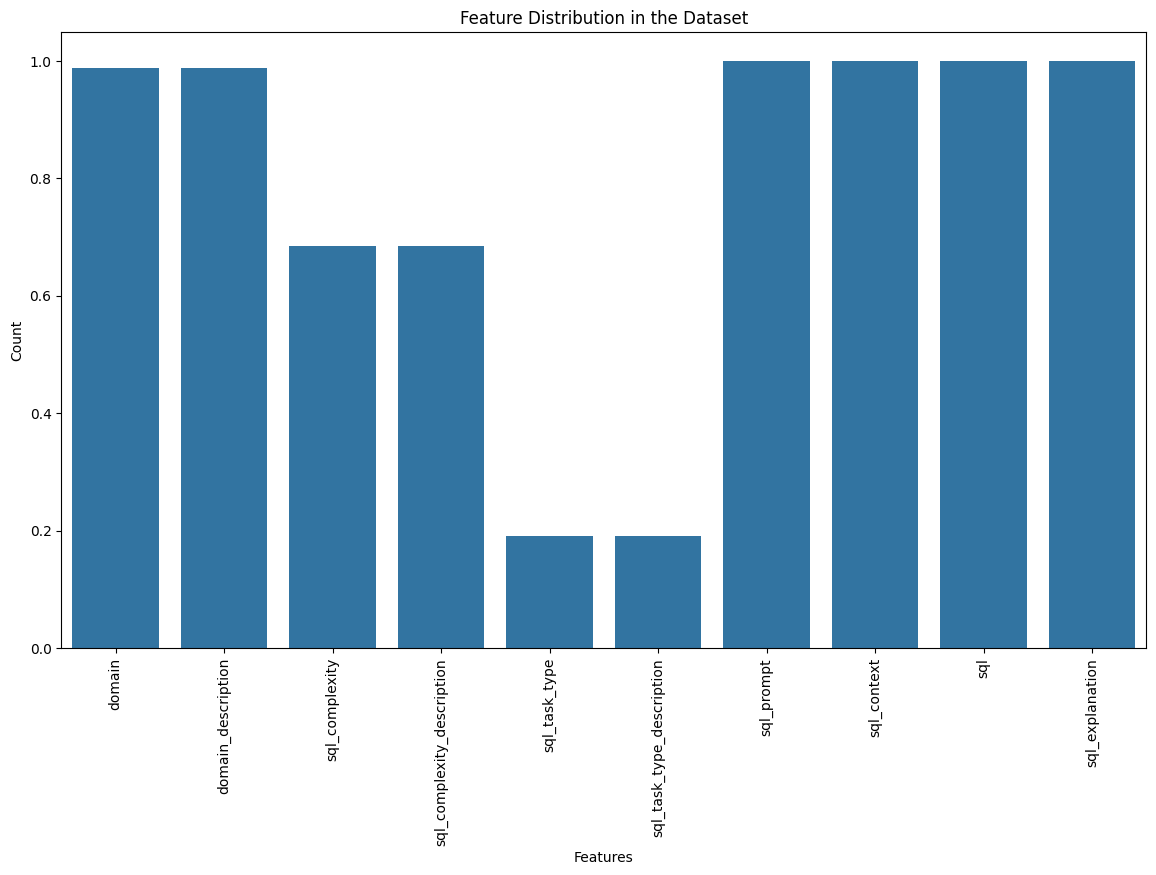

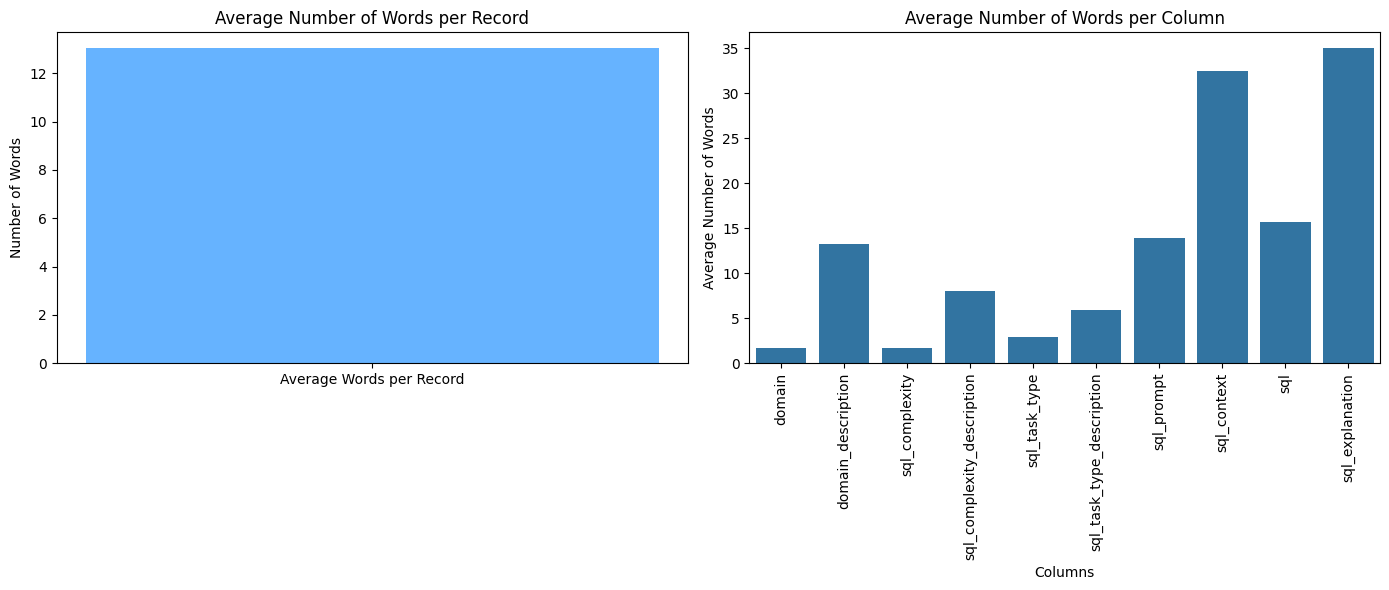

In [311]:
vis_suite = VisualizationTaskSuite(dataset_1000_pd, results)

#vis_suite.plot_feature_cardinality()
#vis_suite.plot_row_uniqueness()
#vis_suite.plot_feature_distribution()
#vis_suite.plot_num_words_per_record()

vis_suite.visualize_all()

### Testing LLM-as-a-Judge Evaluation

In [291]:
dataset_10_pd = dataset_1000_pd.head(10)

In [292]:
if code_lang == "sql":
    task_5 = NL2SQLEvaluationTaskSuite(
        llm_suite=llm_suite, dataset=dataset_10_pd, code_lang="sql"
    )
elif code_lang == "python":
    task_5 = NL2PythonEvaluationTaskSuite(
        llm_suite=llm_suite, dataset=dataset_10_pd, code_lang="python"
    )
else:
    task_5 = BaseEvaluationTaskSuite(llm_suite, dataset_10_pd)
results_5 = task_5.llm_as_a_judge_evaluation(**eval_kwargs)
table_5 = task_5.output_dataset

In [296]:
print(results_5)
table_5.head()

{'llm_as_a_judge_score': 3.5800000000000005}


,id,domain,domain_description,sql_complexity,sql_complexity_description,sql_task_type,sql_task_type_description,sql_prompt,sql_context,sql,sql_explanation,scores,overall_score
0,5097,forestry,Comprehensive data on sustainable forest manag...,single join,"only one join (specify inner, outer, cross)",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total volume of timber sold by eac...,"CREATE TABLE salesperson (salesperson_id INT, ...","SELECT salesperson_id, name, SUM(volume) as to...","Joins timber_sales and salesperson tables, gro...","{'relevance_score': 4, 'relevance_reason': 'Th...",3.6
1,5098,defense industry,"Defense contract data, military equipment main...",aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",List all the unique equipment types and their ...,CREATE TABLE equipment_maintenance (equipment_...,"SELECT equipment_type, SUM(maintenance_frequen...",This query groups the equipment_maintenance ta...,"{'relevance_score': 4, 'relevance_reason': 'Th...",3.6
2,5099,marine biology,"Comprehensive data on marine species, oceanogr...",basic SQL,basic SQL with a simple select statement,analytics and reporting,"generating reports, dashboards, and analytical...",How many marine species are found in the South...,"CREATE TABLE marine_species (name VARCHAR(50),...",SELECT COUNT(*) FROM marine_species WHERE loca...,This query counts the number of marine species...,"{'relevance_score': 4, 'relevance_reason': 'Th...",3.6
3,5100,financial services,Detailed financial data including investment s...,aggregation,"aggregation functions (COUNT, SUM, AVG, MIN, M...",analytics and reporting,"generating reports, dashboards, and analytical...",What is the total trade value and average pric...,"CREATE TABLE trade_history (id INT, trader_id ...","SELECT trader_id, stock, SUM(price * quantity)...",This query calculates the total trade value an...,"{'relevance_score': 4, 'relevance_reason': 'Th...",3.6
4,5101,energy,Energy market data covering renewable energy s...,window functions,"window functions (e.g., ROW_NUMBER, LEAD, LAG,...",analytics and reporting,"generating reports, dashboards, and analytical...",Find the energy efficiency upgrades with the h...,"CREATE TABLE upgrades (id INT, cost FLOAT, typ...","SELECT type, cost FROM (SELECT type, cost, ROW...",The SQL query uses the ROW_NUMBER function to ...,"{'relevance_score': 4, 'relevance_reason': 'Th...",3.6
